In [1]:
import pandas as pd
import numpy as np

import lib.draw as draw
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.metrics import mean_squared_error
import pickle

from tqdm import tqdm

In [2]:
# Ajust to create denser maps
densityX, densityY = 1.5, 2.25

In [3]:
df = pd.read_csv('data/formated_data.csv').drop('Unnamed: 0', axis = 1)

In [4]:
df = df[df.type == 'TakeOn']
df

type  player  team  success      x      y   endX   endY  isShot  \
110     TakeOn  114597  2188        1  0.715  0.296  0.715  0.296   False   
118     TakeOn  322854  2187        0  0.786  0.785  0.786  0.785   False   
142     TakeOn  322852  2187        0  0.424  0.602  0.424  0.602   False   
146     TakeOn  322852  2187        0  0.624  0.439  0.624  0.439   False   
165     TakeOn  105745  2188        1  0.512  0.968  0.512  0.968   False   
...        ...     ...   ...      ...    ...    ...    ...    ...     ...   
243594  TakeOn   24030   297        1  0.516  0.113  0.516  0.113   False   
243746  TakeOn  291653   108        0  0.668  0.106  0.668  0.106   False   
243747  TakeOn  291653   108        0  0.821  0.017  0.821  0.017   False   
243753  TakeOn  322636   108        0  0.785  0.590  0.785  0.590   False   
243762  TakeOn   94891   297        1  0.639  0.348  0.639  0.348   False   

        isGoal  ...  prevForwardAct  prevCross  prevPass  prevDribble    r  \
110      False  ...            True      False      True        False  0.0   
118      False  ...            True      False      True        False  0.0   
142      False  ...            True      False      True        False  0.0   
146      False  ...            True      False      True        False  0.0   
165      False  ...            True      False      True        False  0.0   
...        ...  ...             ...        ...       ...          ...  ...   
243594   False  ...           False      False      True        False  0.0   
243746   False  ...           False      False      True        False  0.0   
243747   False  ...           False      False     False        False  0.0   
243753   False  ...            True      False      True        False  0.0   
243762   False  ...            True      False      True        False  0.0   

          a  rebound_r  rebound_a  dribble_r  dribble_a  
110     0.5   0.000000   0.500000   0.057697   0.321324  
118     0.5   0.012083   0.182100   0.796222   0.123869  
142     0.5   0.205798   0.157489   0.051039   0.493762  
146     0.5   0.339094   0.217387   0.571239   0.910358  
165     0.5   0.000000   0.500000   0.100000   0.500000  
...     ...        ...        ...        ...        ...  
243594  0.5   0.000000   0.500000   0.023022   0.654499  
243746  0.5   0.085586   0.333778   0.085586   0.333778  
243747  0.5   0.312128   0.914339   0.312128   0.914339  
243753  0.5   0.095037   0.226469   0.095037   0.226469  
243762  0.5   0.000000   0.500000   0.003000   0.250000  

[9674 rows x 37 columns]

# Generate gradients

In [5]:
def plot_xdmap(xdmap, fromX, fromY):
    draw.pitch()
    cmap = np.zeros((len(xdmap),4))
    cmap[:,0] = 0; cmap[:,1] = 0; cmap[:,2] = 0; cmap[:,3] = xdmap.xd
    plt.scatter(xdmap.endX, xdmap.endY, s = 15, c = cmap, marker = 's', linewidth=0, zorder = 10)
    plt.scatter(fromX, fromY, s = 15, c = 'C1', marker = 's', linewidth=0, zorder = 11)

In [6]:
def plot_map(clf, fromX, fromY):
    xdmap = [[fromX/100, fromY/100, i/100, j/100] for i in range(0, 100) for j in np.arange(0, 100, 1.5)]
    xdmap = pd.DataFrame(xdmap, columns=['x','y', 'endX', 'endY'])
    xdmap['xd'] = clf.predict_proba(xdmap[['x','y', 'endX', 'endY']])[:,0]

    xdmap.x *= 100
    xdmap.y *= 100
    xdmap.endX *= 100
    xdmap.endY *= 100

    plot_xdmap(xdmap, fromX, fromY)

## Optimization
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('n_units_l{}'.format(i), 4, 128))

    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    lr = trial.suggest_float('learning_rate', 0.00001, 0.05)
    lr_type = trial.suggest_categorical('learning_rate_type', ['constant', 'invscaling', 'adaptive'])
    max_iterations = trial.suggest_int('epochs', 20, 750)
    early_stop = trial.suggest_categorical('early_stop', [False, True])
    
    clf = MLPClassifier(hidden_layer_sizes=layers, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iterations, early_stopping=early_stop)
    clf.fit(df[['x', 'y', 'xdribble', 'ydribble']], df['success'])

    pred = clf.predict_proba(df[['x', 'y', 'xdribble', 'ydribble']])[:,1]

    return mean_squared_error(pred, df['success'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
study.best_params

In [7]:
clf = MLPClassifier(hidden_layer_sizes=[64, 64, 64, 64, 64], activation='relu', learning_rate_init=0.001425740966620266, learning_rate='adaptive', max_iter=500)
clf.fit(df[['x', 'y', 'xdribble', 'ydribble']], df['success'])
pickle.dump(clf, open('matrix/dribble_gradient.sav', 'wb'))

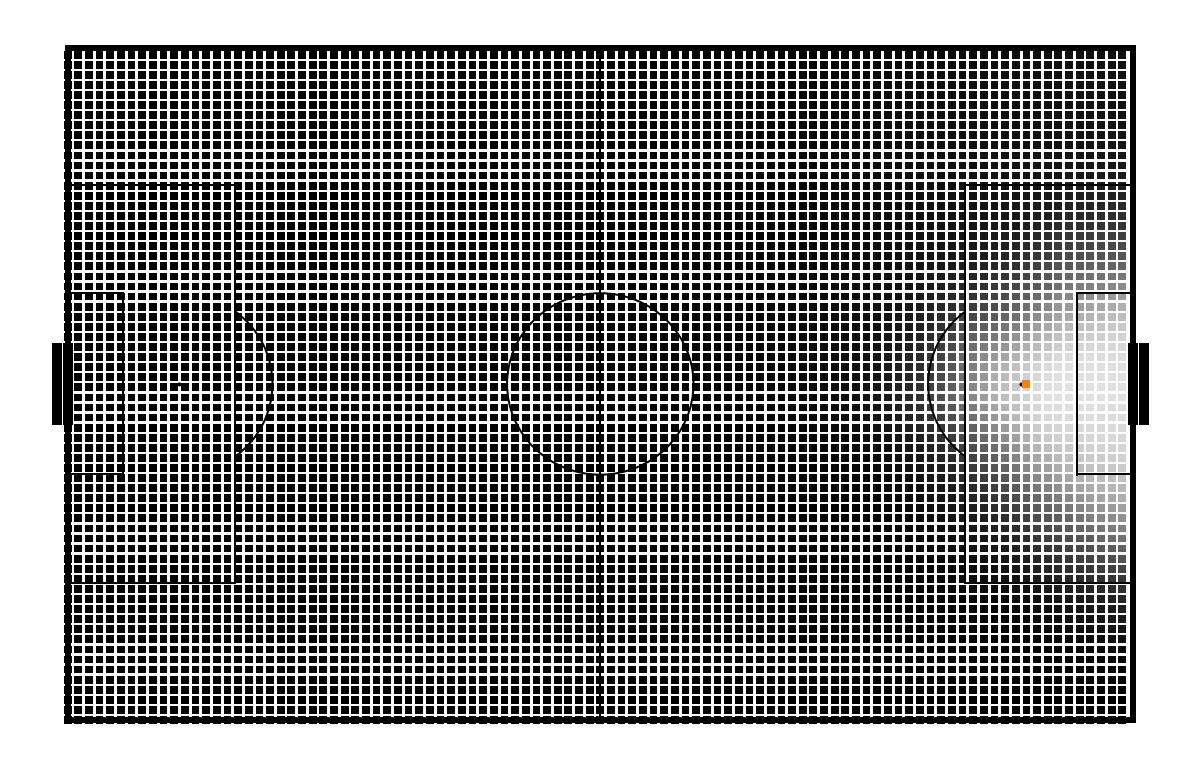

In [8]:
plot_map(clf, 90, 50)

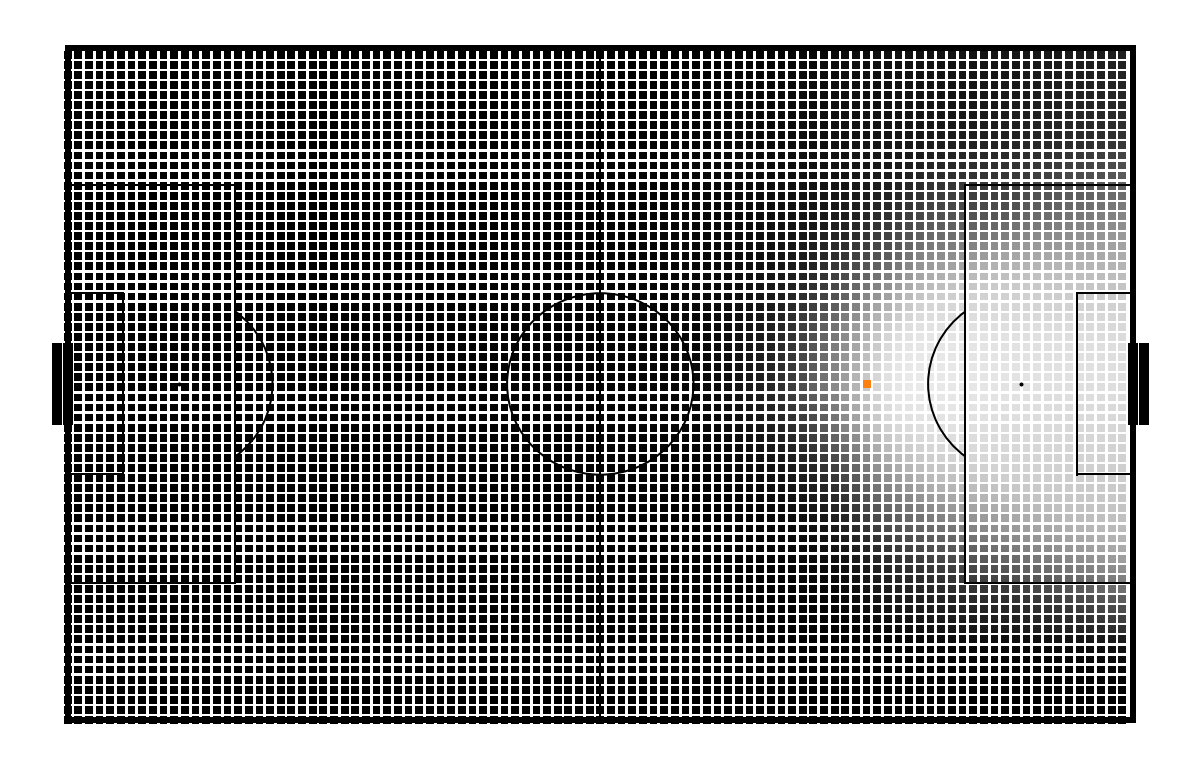

In [9]:
plot_map(clf, 75, 50)

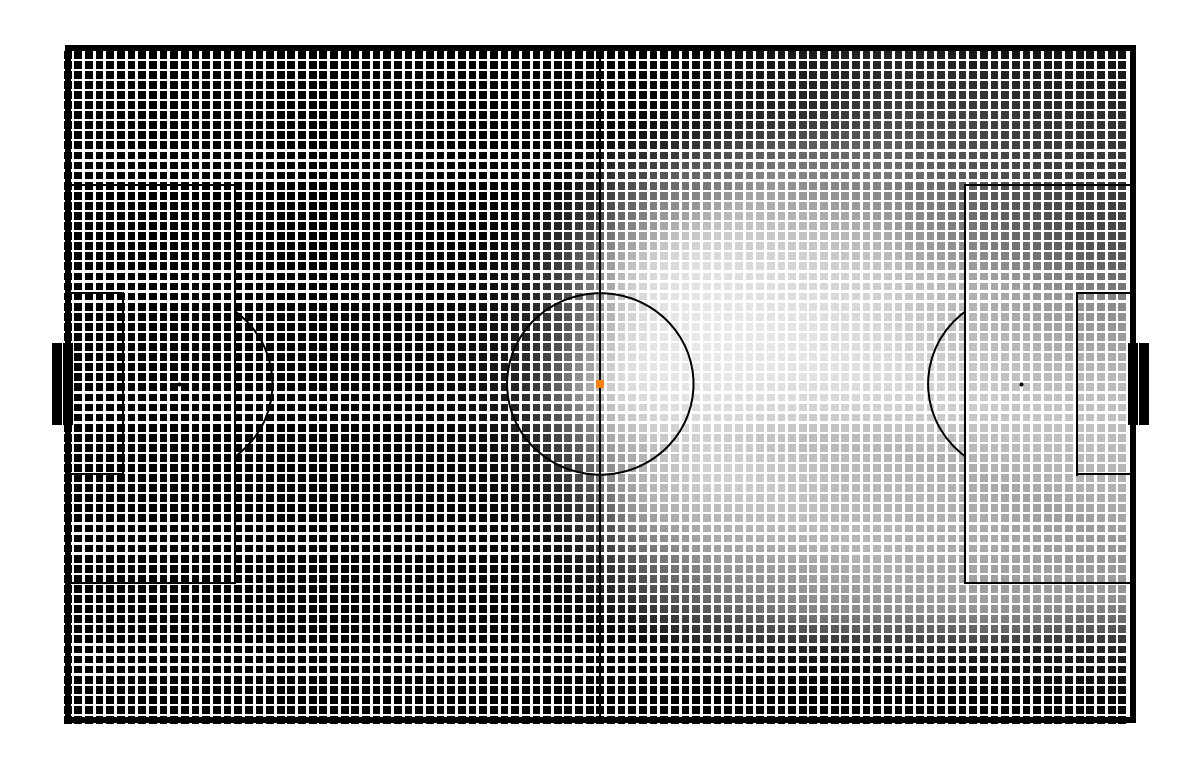

In [10]:
plot_map(clf, 50, 50)

In [11]:
plot_map(clf, 80, 85)
plt.savefig('mams report/dribblemat.png', dpi=500)

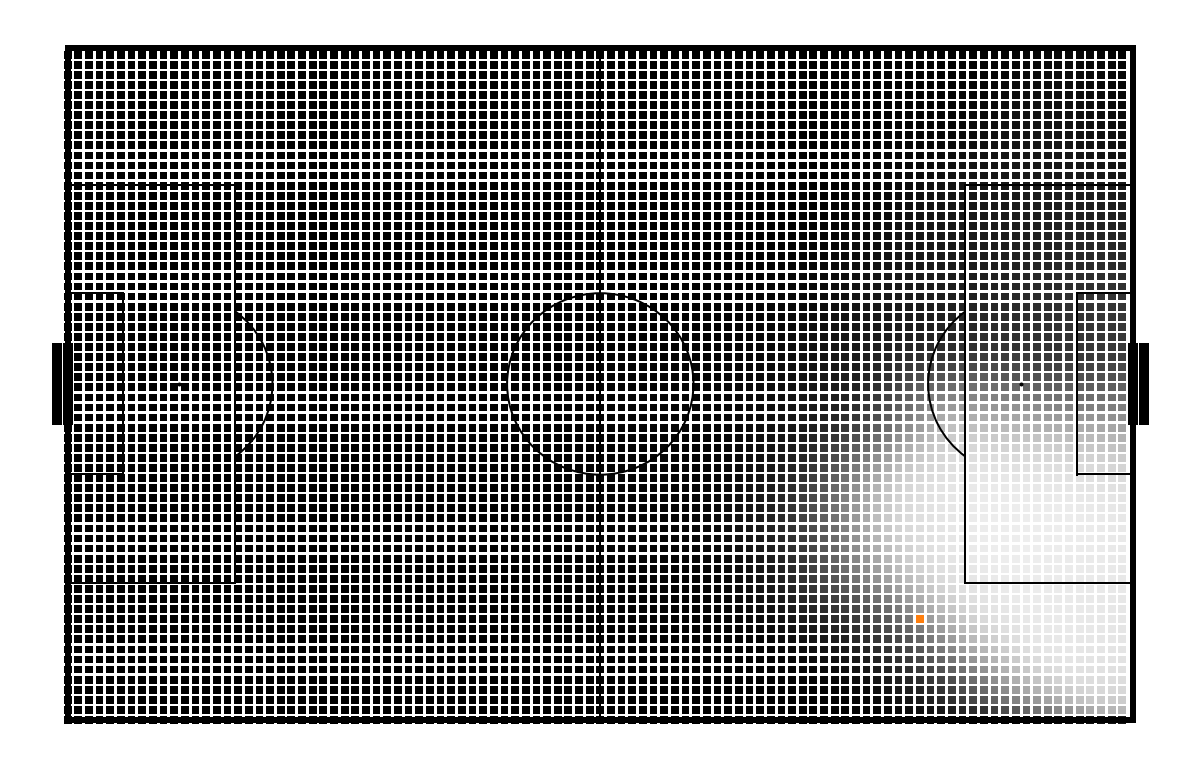

In [12]:
plot_map(clf, 80, 15)

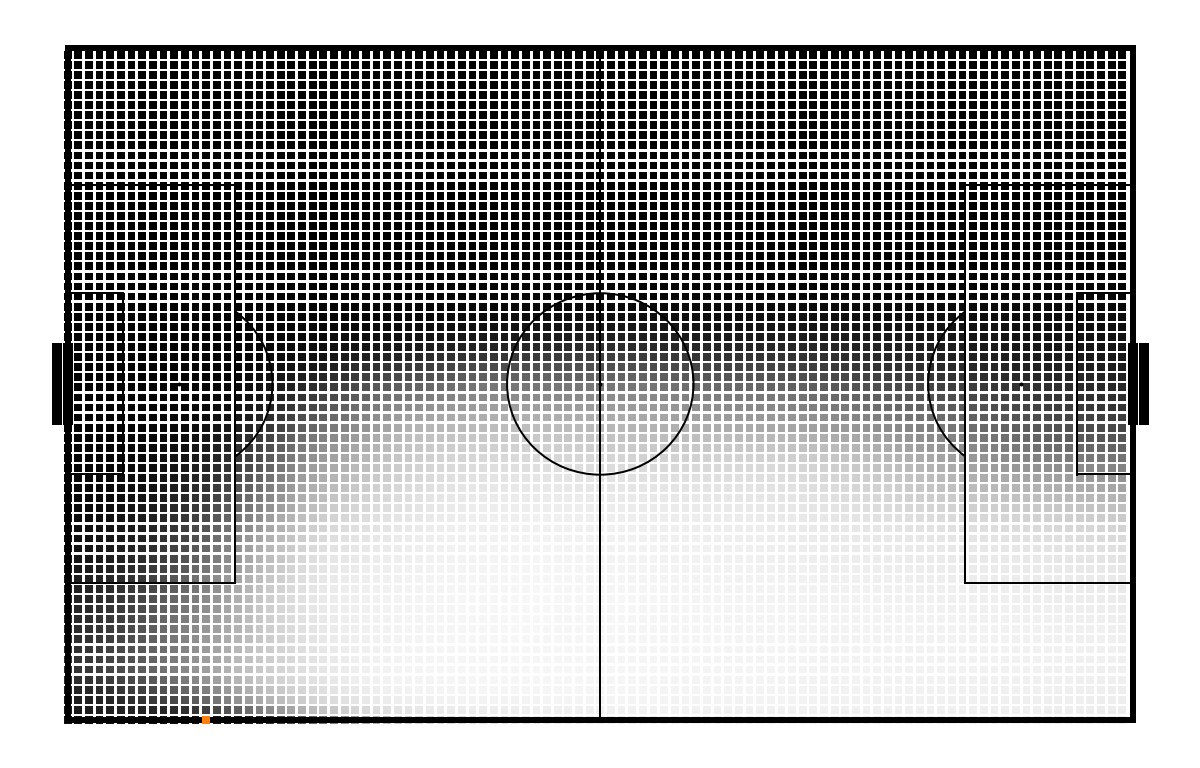

In [13]:
plot_map(clf, 13, 0)